<a href="https://colab.research.google.com/github/JoernStoehler/uni-deeplearning/blob/master/D2_Joern_Stoehler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, you will code a regression model from scratch, to predict housing prices in California.

Each record in the data (x) is comprised of 9 fields which include the size of the apartment in $m^2$, number of rooms, the location, etc.

The data is split into a training and test set. There are 8 features for one data entry (8 columns for one row) and the targets (labels) are the median values of the houses at a location in $k$.

The model will be a linear regression model:
$f_w (x) = w_1 x_1 + ... + w_{8} x_{8} + b$
where w,b are the model parameters we want to learn using gradient descent.

The data can be downloaded by executing the already given cell below. You can find more information about the dataset on https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset .

Steps:

1. Implement a function to compute the loss: loss = (prediction - y)$^2$. Note that this function should calculate the average loss over all training samples. In short: implement a function which calculates the MSE-loss.
2. Plot the predictions over the ground truth using `matplotlib`. Label the x and y axis appropriately and show the individual points **without** connecting them with lines.
3. Implement the body functions of the `__init__` and `forward` methods of `LinearRegressor` to hold the model parameters w and b (both initialised using a normal distribution) and implement its correct linear regression equation function. Instantiate your module and show its trainable parameters to verify that w and b are within them.
4.  Implement the body of the following function to perform one training step, given a torch module (which contains the variables of your model), the training data and labels, as well as the optimizer. Use your MSEloss function to compute the loss and back-propagate the gradients using `.backward()`. Update the model weights using `optimizer.step()`. Remember to reset the gradients before the step.
5. Implement the body of the function for training and evaluating given a number of training steps. After every 1000 training steps the function should optionally (i.e., controlled via the `verbose` flag) output the loss on the training set, as well as the test set. The function should return the test set loss on the **last** step.
6. Instantiate your model again and wrap it in a suitable stochastic gradient descent optimizer. Use a learning rate of 0.001. Run your function for training and evaluation for 10,000 training steps. At the end of it, show the trained model parameters. Compare the final loss to your baseline loss.
7. Plot the test set predictions over the test set ground truth, and additionally compute the loss and the Pearson correlation (see `sklearn` cell).
8. Do not feed the entire training set for every iteration (gradient descent), but rather a random subset of 32 training examples (this is called a `batch` and the optimization process `stochastic` gradient descent). Use the given function template and implement its body. Run the function for the same number of iterations and with the same learning rate. Show its loss and plot the predictions. Compare with your baseline and full-batch gradient descent. `Hint:` Implement without replacement, i.e., each sample is taken only once. In order to train a model from scratch, you need to re-instantiate it and wrap it in a new optimizer.
9. Benchmark full-batch gradient descent and stochastic gradient descent for a set of different learning rates ($[.1, .01, .001, .0001, .00001]$). Use 10k iterations. Print, plot, and compare the losses on the last step for each training algorithm and each learning rate. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!
10. Benchmark full-batch gradient descent and stochastic gradient descent for different iterations ($[10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]$). Keep the learning rate fixed to $0.0001$. Print, plot, and compare the loss on the last step for each training algorithm and the different number of iterations. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!
11. Fill in the class body to implement SGD without automatic differentiation. Do not use torch.nn.Parameter and instead implement a manual backward call. Fill in the new step function that does not use autograd but calls this custom backward call. The gradients of the two parameters can be computed by using the following formulas: $\delta w = 2 \frac{1}{N} \sum_{i=1}^{N}x_i (\hat{y}_i-y_i)$ and $\delta b = 2 \frac{1}{N} \sum_{i=1}^{N}(\hat{y}_i-y_i)$, where $N$ is the batch size and $\hat{y}_i$ the prediction for the $i^{th}$ instance. Test the implementation with the call to training already given. Plot the predictions on the test set and compute the MSELoss and Pearson R.

`Note:` Do not use loops for the backpropagation in a batch.

In [1]:
# import necessary functions
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
import torch
import typing

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
print("numpy: " + np.__version__)
print("torch: " + torch.__version__)
print("sklearn: " + sklearn.__version__)
print("scipy: " + scipy.__version__)

numpy: 1.25.2
torch: 2.2.1+cu121
sklearn: 1.2.2
scipy: 1.11.4


We first load and standardise the features (x_train and x_test), such that the mean is 0 and the standard deviation is 1 for each of the 8 features, i.e. standardise each column. For this purpose, we use the following formula: $x_{norm} = \frac{x - \mu}{\sigma} $, where $\mu$ is the mean and $\sigma$ is the standard deviation. We also need to normalise the labels (y_train and y_test) in the range [0-1]. This can be done by applying the following formula: $y_{norm} = \frac{y-\min{y}}{\max{y}-\min{y}}$. The normalisation parameters for both features and labels are computed on the training set.

In [2]:
# Download and load the data using sklearn
X, y = fetch_california_housing(return_X_y=True)

# Cast to 32 bits which is the default in torch
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split the data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

# Compute feature statistics on training set
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Normalise training set features
X_train = (X_train - mean) / std
print(f'Feature mean (train): {X_train.mean()}')
print(f'Feature std (train): {X_train.std()}')

# Normalise test set features
X_test = (X_test - mean) / std
print(f'Feature mean (test): {X_test.mean()}')
print(f'Feature std (test): {X_test.std()}')

# Compute label statistics on training set
maximum = y_train.max()
minimum = y_train.min()

# Normalise training set labels
y_train = (y_train - minimum) / (maximum-minimum)
print(f'Label max (train): {y_train.max()}')
print(f'Label min (train): {y_train.min()}')

# Normalise test set labels
y_test = (y_test - minimum) / (maximum-minimum)
print(f'Label max (test): {y_test.max()}')
print(f'Label min (test): {y_test.min()}')

# Convert everything from numpy arrays to tensors:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

X_train shape: (16512, 8)
X_test shape: (4128, 8)
y_train shape: (16512,)
y_test shape: (4128,)
Feature mean (train): -1.6832045730552636e-05
Feature std (train): 1.000001072883606
Feature mean (test): 0.01602260023355484
Feature std (test): 1.5549755096435547
Label max (train): 1.0
Label min (train): 0.0
Label max (test): 1.0
Label min (test): 0.015465913340449333


We implement a `LinearRegression` baseline from `sklearn`. This should serve as your reference for what is expected by a state-of-the-art implementation. Your goal throughout this day is to get similar (or maybe even better!) results from the models you implement yourself.

In [3]:
baseline = LinearRegression()
baseline.fit(
    X_train.numpy(),
    y_train.numpy()
)
y_hat = baseline.predict(X_test.numpy())
R = scipy.stats.pearsonr(y_hat, y_test)[0]
print(f'Baseline Pearson R: {R}')

Baseline Pearson R: 0.7672722723781259


1. Implement a function to compute the loss: loss = (prediction - y)$^2$. Note that this function should calculate the average loss over all training samples. In short: implement a function which calculates the MSE-loss.

In [4]:
def MSEloss(prediction, label):
    return ((prediction - label) ** 2).mean()

loss = MSEloss(torch.from_numpy(y_hat), y_test)
print(f'Baseline MSE: {loss}')

Baseline MSE: 0.02439041994512081


2. Plot the predictions over the ground truth using `matplotlib`. Label the x and y axis appropriately and show the individual points **without** connecting them with lines.

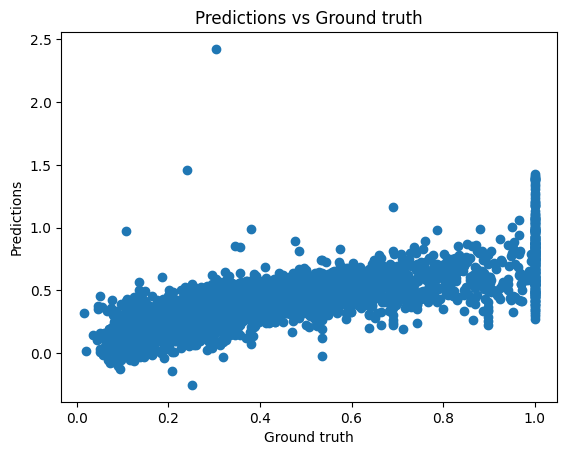

In [5]:
# 2. Plot the predictions over the ground truth using `matplotlib`. Label the x and y axis appropriately and show the individual points **without** connecting them with lines.
plt.scatter(y_test, y_hat)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground truth')
plt.show()

3. Implement the body functions of the `__init__` and `forward` methods of `LinearRegressor` to hold the model parameters w and b (both initialised using a normal distribution) and implement its correct linear regression equation function (using a matrix multiplication). Instantiate your module and show its trainable parameters to verify that w and b are within them.

In [6]:
class LinearRegressor(torch.nn.Module):
    r"""Class implementing linear regression model.

    Args:
        num_features: number of input features
        num_outputs: number of output labels
    """
    def __init__(self, num_features: int, num_outputs: int = 1):
        super(LinearRegressor, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(num_features, num_outputs)) # [num_features, num_outputs]
        self.b = torch.nn.Parameter(torch.randn(num_outputs)) # [num_outputs]

    def forward(self, x): # [batch, num_features] -> [batch, num_outputs]
        return torch.mm(x, self.w) + self.b

    def __repr__(self):
        return f'LinearRegressor(w: {self.w.shape}, b: {self.b.shape})'

# instantiate the model and show its trainable parameters
model = LinearRegressor(num_features=X_train.shape[1], num_outputs=1)
for name, param in model.named_parameters():
    print(f'{name}: {param.shape} requires_grad={param.requires_grad}')

w: torch.Size([8, 1]) requires_grad=True
b: torch.Size([1]) requires_grad=True


4.  Implement the body of the following function to perform one training step, given a torch module (which contains the variables of your model), the training data and labels, as well as the optimizer. Use your MSEloss function to compute the loss and back-propagate the gradients using `.backward()`. Update the model weights using `optimizer.step()`. Remember to reset the gradients before the step.

In [7]:
def autograd_train_step(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    X: torch.Tensor,
    y: torch.Tensor
) -> torch.Tensor:
    r"""Single autograd training step.

    Function should use MSEloss defined above to compute loss,
    then perform a single optimization step to update model weights,
    and finally return the resulting loss.

    Args:
        model: pytorch model to be trained
        optimizer: optimizer wrapping pytorch model
        X: pytorch tensor containing features
        y: pytorch tensor containing labels
    Returns:
        torch.Tensor: loss at current step
    """
    y_hat = model(X).squeeze()
    loss = MSEloss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss # training loss

5. Implement the body of the function for training and evaluating given a number of training steps. After every 1000 training steps the function should optionally (i.e., controlled via the `verbose` flag) output the loss on the training set, as well as the test set. The function should return the test set loss on the **last** step.

In [8]:
def train_and_evaluate(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    iterations: int,
    train_step: typing.Callable,
    verbose: bool = False
) -> torch.Tensor:
    r"""Train and evaluate model.

    Args:
        model: pytorch model to be trained
        optimizer: optimizer wrapping pytorch model
        X_train: pytorch tensor containing training features
        y_train: pytorch tensor containing training labels
        X_test: pytorch tensor containing test features
        y_test: pytorch tensor containing test labels
        iterations: number of iterations for gradient descent
        train_step: function implementing single training step
        verbose: flag controlling whether output should be printed at every iteration

    Returns:
        torch.Tensor: loss function at the last step
    """

    for i in range(iterations):
        train_loss = train_step(model, optimizer, X_train, y_train)
        if verbose and i % 1000 == 999:
            test_loss = MSEloss(model(X_test), y_test)
            print(f'Iteration {i+1}, train_loss: {train_loss} test_loss: {test_loss}')

    test_loss = MSEloss(model(X_test), y_test)
    return test_loss

6. Instantiate your model again and wrap it in a suitable stochastic gradient descent optimizer. Use a learning rate of 0.001. Run your function for training and evaluation for 10,000 training steps. At the end of it, show the trained model parameters. Compare the final loss to your baseline loss.

In [9]:
model = LinearRegressor(num_features=X_train.shape[1], num_outputs=1)

# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
test_loss = train_and_evaluate(
    model,
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    iterations=10_000,
    train_step=autograd_train_step,
    verbose=True
)

# show trained parameters
for name, param in model.named_parameters():
    print(f'{name}: {param.data}')

# compare final loss to baseline loss
print(f'Final test MSE loss: {test_loss}')
print(f'Baseline test MSE loss: {loss}')

Training on cpu
Iteration 1000, train_loss: 0.49607980251312256 test_loss: 0.5104250907897949
Iteration 2000, train_loss: 0.280355304479599 test_loss: 0.403293639421463
Iteration 3000, train_loss: 0.2073742002248764 test_loss: 0.32073894143104553
Iteration 4000, train_loss: 0.1560993492603302 test_loss: 0.25199028849601746
Iteration 5000, train_loss: 0.1191680058836937 test_loss: 0.20236705243587494
Iteration 6000, train_loss: 0.092525415122509 test_loss: 0.16751620173454285
Iteration 7000, train_loss: 0.07328222692012787 test_loss: 0.1432691216468811
Iteration 8000, train_loss: 0.05936450883746147 test_loss: 0.12653093039989471
Iteration 9000, train_loss: 0.04928310588002205 test_loss: 0.1150842010974884
Iteration 10000, train_loss: 0.04196789860725403 test_loss: 0.1073504313826561
w: tensor([[ 0.0181],
        [ 0.0454],
        [ 0.3075],
        [-0.2720],
        [ 0.0099],
        [-0.0105],
        [-0.1686],
        [-0.1410]])
b: tensor([0.3940])
Final test MSE loss: 0.1073504

7. Plot the test set predictions over the test set ground truth, and additionally compute the loss and the Pearson correlation (see `sklearn` cell).

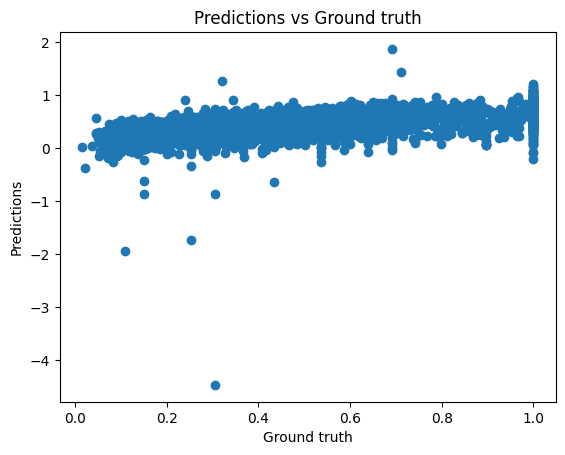

Pearson R: 0.5249055480962612
Baseline Pearson R: 0.7672722723781259


In [10]:
# 7. Plot the test set predictions over the test set ground truth, and additionally compute the loss and the Pearson correlation (see `sklearn` cell).
y_hat = model(X_test).detach()
plt.scatter(y_test.cpu(), y_hat.cpu())
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground truth')
plt.show()

test_R = scipy.stats.pearsonr(y_hat[:,0].cpu(), y_test.cpu())[0]
print(f'Pearson R: {test_R}')
print(f'Baseline Pearson R: {R}')

8. Do not feed the entire training set for every iteration (gradient descent), but rather a random subset of 32 training examples (this is called a `batch` and the optimization process stochastic (or rather mini-batch) gradient descent). Use the given function template and implement its body. Run the function for the same number of iterations and with the same learning rate. Show its loss and plot the predictions. Compare with your baseline and full-batch gradient descent. In order to train a model from scratch, you need to re-instantiate it and wrap it in a new optimizer.

In [11]:
def train_and_evaluate_on_batches(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    iterations: int,
    batch_size: int,
    train_step: typing.Callable,
    verbose: bool = False
):
    r"""Train and evaluate model on batches.

    Args:
        model: pytorch model to be trained
        optimizer: optimizer wrapping pytorch model
        X_train: pytorch tensor containing training features
        y_train: pytorch tensor containing training labels
        X_test: pytorch tensor containing test features
        y_test: pytorch tensor containing test labels
        iterations: number of iterations for gradient descent
        train_step: function implementing single training step
        verbose: flag controlling whether output should be printed at every iteration

    Returns:
        torch.Tensor: loss function at the last step
    """

    for i in range(iterations):
        indices = torch.randperm(X_train.shape[0])[:batch_size]
        train_loss = train_step(model, optimizer, X_train[indices], y_train[indices])
        if verbose and i % 1000 == 999:
            test_loss = MSEloss(model(X_test), y_test)
            print(f'Iteration {i+1}, train_loss: {train_loss} test_loss: {test_loss}')

    test_loss = MSEloss(model(X_test), y_test)
    return test_loss

model_batch = LinearRegressor(num_features=X_train.shape[1], num_outputs=1).to(device)
optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr=0.001)
test_loss_batch = train_and_evaluate_on_batches(
    model_batch,
    optimizer_batch,
    X_train,
    y_train,
    X_test,
    y_test,
    iterations=10_000,
    batch_size=32,
    train_step=autograd_train_step,
    verbose=True
)

Iteration 1000, train_loss: 0.1751168668270111 test_loss: 0.37235552072525024
Iteration 2000, train_loss: 0.07399319112300873 test_loss: 0.26792916655540466
Iteration 3000, train_loss: 0.07107874751091003 test_loss: 0.240248903632164
Iteration 4000, train_loss: 0.08614343404769897 test_loss: 0.20833364129066467
Iteration 5000, train_loss: 0.049930863082408905 test_loss: 0.18352463841438293
Iteration 6000, train_loss: 0.03055524453520775 test_loss: 0.1675412505865097
Iteration 7000, train_loss: 0.07813595235347748 test_loss: 0.15516974031925201
Iteration 8000, train_loss: 0.10018771886825562 test_loss: 0.14535078406333923
Iteration 9000, train_loss: 0.0966862291097641 test_loss: 0.13559317588806152
Iteration 10000, train_loss: 0.03187186270952225 test_loss: 0.12872596085071564


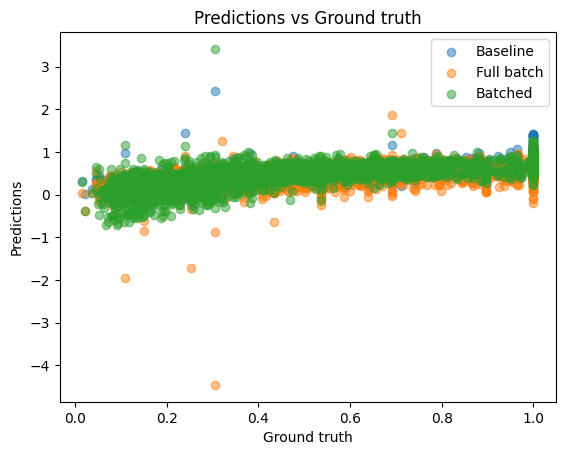

Baseline test MSE loss: 0.02439041994512081
Full batch test MSE loss: 0.1073504313826561
Batched test MSE loss: 0.12872596085071564


In [12]:
# plot predictions
y_hat_batch = model_batch(X_test).detach()
plt.scatter(y_test.cpu(), baseline.predict(X_test.cpu().numpy()), label='Baseline', alpha=0.5)
plt.scatter(y_test.cpu(), y_hat.cpu(), label='Full batch', alpha=0.5)
plt.scatter(y_test.cpu(), y_hat_batch.cpu(), label='Batched', alpha=0.5)
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground truth')
plt.show()

# compare baseline, full-batch and batch losses
print(f'Baseline test MSE loss: {loss}')
print(f'Full batch test MSE loss: {test_loss}')
print(f'Batched test MSE loss: {test_loss_batch}')

9. Benchmark full-batch gradient descent and stochastic gradient descent for a set of different learning rates ($[.1, .01, .001, .0001, .00001]$). Use 10k iterations. Print, plot, and compare the losses on the last step for each training algorithm and each learning rate. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!

In [13]:
set_of_lr = [.1, .01, .001, .0001, .00001]
iterations = 10_000
batch_size = 32

trained_models = {"full-batch": {}, "batched": {}}

In [14]:
# batched training
for lr in set_of_lr:
    print(f'Batched training with lr={lr}')
    model_batch = LinearRegressor(num_features=X_train.shape[1], num_outputs=1).to(device)
    optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr=lr)
    test_loss_batch = train_and_evaluate_on_batches(
        model_batch,
        optimizer_batch,
        X_train,
        y_train,
        X_test,
        y_test,
        iterations=iterations,
        batch_size=batch_size,
        train_step=autograd_train_step,
        verbose=False
    )
    trained_models["batched"][lr] = {
        "model": model_batch,
        "last_test_loss": test_loss_batch
    }

Batched training with lr=0.1
Batched training with lr=0.01
Batched training with lr=0.001
Batched training with lr=0.0001
Batched training with lr=1e-05


In [15]:
# full-batch training
for lr in set_of_lr:
    print(f'Full-batch training with lr={lr}')
    model = LinearRegressor(num_features=X_train.shape[1], num_outputs=1).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    test_loss = train_and_evaluate(
        model,
        optimizer,
        X_train,
        y_train,
        X_test,
        y_test,
        iterations=iterations,
        train_step=autograd_train_step,
        verbose=False
    )
    trained_models["full-batch"][lr] = {
        "model": model,
        "last_test_loss": test_loss
    }

Full-batch training with lr=0.1
Full-batch training with lr=0.01
Full-batch training with lr=0.001
Full-batch training with lr=0.0001
Full-batch training with lr=1e-05


full-batch:
  lr=0.1, last test loss=0.0970357209444046
  lr=0.01, last test loss=0.09703472256660461
  lr=0.001, last test loss=0.10527446120977402
  lr=0.0001, last test loss=0.5088732242584229
  lr=1e-05, last test loss=30.04164695739746
batched:
  lr=0.1, last test loss=inf
  lr=0.01, last test loss=inf
  lr=0.001, last test loss=0.15795572102069855
  lr=0.0001, last test loss=0.4698582589626312
  lr=1e-05, last test loss=2.399325370788574


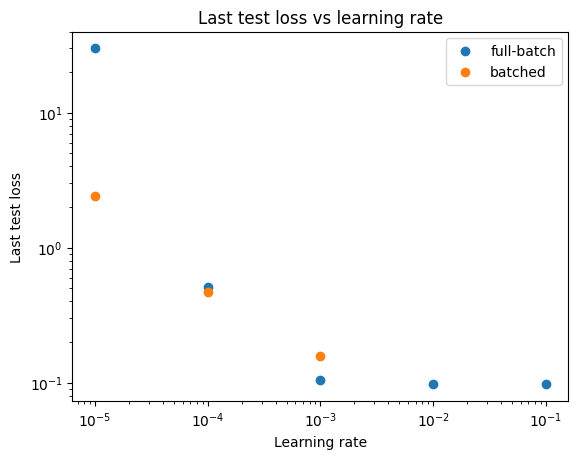

In [16]:
# Print, plot, and compare the losses on the last step for each training algorithm and each learning rate. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!

# print losses
for training_type in trained_models:
    print(f'{training_type}:')
    for lr, data in trained_models[training_type].items():
        print(f'  lr={lr}, last test loss={data["last_test_loss"]}')

# plot losses
plt.xlabel('Learning rate')
plt.ylabel('Last test loss')
plt.title('Last test loss vs learning rate')
for training_type in trained_models:
    points = []
    for lr, data in trained_models[training_type].items():
        points.append((lr, data["last_test_loss"]))
    points = torch.tensor(points).detach().cpu().numpy()
    plt.scatter(*zip(*points), label=training_type)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

10. Benchmark full-batch gradient descent and stochastic gradient descent for different iterations ($[10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]$). Keep the learning rate fixed to $0.0001$. Print, plot, and compare the loss on the last step for each training algorithm and the different number of iterations. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!

In [17]:
lr = 0.0001
set_of_iterations = [10, 100, 1_000, 2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000]
batch_size = 32

trained_models_ex10 = {"full-batch": {}, "batched": {}}

In [18]:
# batched training

for iterations in set_of_iterations:
    print(f'Batched training with iterations={iterations}')
    model_batch = LinearRegressor(num_features=X_train.shape[1], num_outputs=1).to(device)
    optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr=lr)
    test_loss_batch = train_and_evaluate_on_batches(
        model_batch,
        optimizer_batch,
        X_train,
        y_train,
        X_test,
        y_test,
        iterations=iterations,
        batch_size=batch_size,
        train_step=autograd_train_step,
        verbose=False
    )
    trained_models_ex10["batched"][iterations] = {
        "model": model_batch,
        "last_test_loss": test_loss_batch
    }

Batched training with iterations=10
Batched training with iterations=100
Batched training with iterations=1000
Batched training with iterations=2000
Batched training with iterations=3000
Batched training with iterations=4000
Batched training with iterations=5000
Batched training with iterations=6000
Batched training with iterations=7000
Batched training with iterations=8000
Batched training with iterations=9000
Batched training with iterations=10000


In [19]:
# full-batch training

for iterations in set_of_iterations:
    print(f'Full-batch training with iterations={iterations}')
    model = LinearRegressor(num_features=X_train.shape[1], num_outputs=1).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    test_loss = train_and_evaluate(
        model,
        optimizer,
        X_train,
        y_train,
        X_test,
        y_test,
        iterations=iterations,
        train_step=autograd_train_step,
        verbose=False
    )
    trained_models_ex10["full-batch"][iterations] = {
        "model": model,
        "last_test_loss": test_loss
    }

Full-batch training with iterations=10
Full-batch training with iterations=100
Full-batch training with iterations=1000
Full-batch training with iterations=2000
Full-batch training with iterations=3000
Full-batch training with iterations=4000
Full-batch training with iterations=5000
Full-batch training with iterations=6000
Full-batch training with iterations=7000
Full-batch training with iterations=8000
Full-batch training with iterations=9000
Full-batch training with iterations=10000


full-batch:
  iterations=10, last test loss=6.17009162902832
  iterations=100, last test loss=60.54906463623047
  iterations=1000, last test loss=2.938817024230957
  iterations=2000, last test loss=8.419001579284668
  iterations=3000, last test loss=2.5399680137634277
  iterations=4000, last test loss=5.642299175262451
  iterations=5000, last test loss=4.012495040893555
  iterations=6000, last test loss=3.187926769256592
  iterations=7000, last test loss=0.8828474879264832
  iterations=8000, last test loss=0.6251730918884277
  iterations=9000, last test loss=0.7634313702583313
  iterations=10000, last test loss=0.4232490062713623
batched:
  iterations=10, last test loss=23.937686920166016
  iterations=100, last test loss=35.06883239746094
  iterations=1000, last test loss=27.85030174255371
  iterations=2000, last test loss=2.852329969406128
  iterations=3000, last test loss=3.5100255012512207
  iterations=4000, last test loss=1.493563175201416
  iterations=5000, last test loss=0.580238

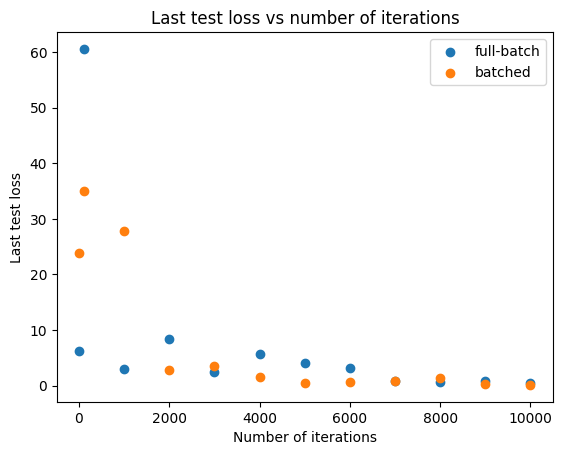

In [20]:
# Print, plot, and compare the losses on the last step for each training algorithm and each number of iterations. What do you observe? What does it mean? Find a proper way to present the information in the plots such that your takeaway message is clear!

# print losses
for training_type in trained_models_ex10:
    print(f'{training_type}:')
    for iterations, data in trained_models_ex10[training_type].items():
        print(f'  iterations={iterations}, last test loss={data["last_test_loss"]}')

# plot losses
plt.xlabel('Number of iterations')
plt.ylabel('Last test loss')
plt.title('Last test loss vs number of iterations')
for training_type in trained_models_ex10:
    points = []
    for iterations, data in trained_models_ex10[training_type].items():
        points.append((iterations, data["last_test_loss"]))
    points = torch.tensor(points).detach().cpu().numpy()
    plt.scatter(*zip(*points), label=training_type)
plt.legend()
plt.show()


11. Fill in the class body to implement SGD without automatic differentiation. Do not use torch.nn.Parameter and instead implement a manual backward call. Fill in the new step function that does not use autograd but calls this custom backward call. The gradients of the two parameters can be computed by using the following formulas: $\delta w = 2 \frac{1}{N} \sum_{i=1}^{N}x_i (\hat{y}_i-y_i)$ and $\delta b = 2 \frac{1}{N} \sum_{i=1}^{N}(\hat{y}_i-y_i)$, where $N$ is the batch size and $\hat{y}_i$ the prediction for the $i^{th}$ instance. Test the implementation with the call to training already given. Plot the predictions on the test set and compute the MSELoss and Pearson R.
`Note:` Do not use loops for the backpropagation in a batch.

In [21]:
class CustomLinearRegressor:
    """Custom linear regression class.

    Args:
        num_features: number of features in your linear regression
        num_outputs: number of outputs. Default: 1
        lr: learning rate for gradient descent

    """
    def __init__(self, num_features: int, num_outputs: int = 1, lr: float = 0.001):
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.lr = lr
        self.w = torch.randn(num_features, num_outputs, requires_grad=False)
        self.b = torch.randn(num_outputs, requires_grad=False)

    def __call__(self, x):
        """Forward call function.

        Implement linear regression.

        Args:
            x: data
        """
        return torch.mm(x, self.w) + self.b

    def gradient_descent(self, x, y, y_hat):
        """Backward call function.

        Implement parameter update

        Args:
            x: data
            y: ground truth labels
            y_hat: model predictions
        """
        # y_hat = self(x) = x @ w + b
        # loss = MSE(y_hat, y) = ((y_hat-y)**2).mean()
        # d loss / d w = 2 * (y_hat - y) * d y_hat / d w = 2 * (y_hat - y) * x
        # d loss / d b = 2 * (y_hat - y) * d y_hat / d b = 2 * (y_hat - y)

        # as batched tensors
        # (d loss / d w)[i,j] = 1/batch 1/num_outputs sum_ko  2*(y_hat[k,o]-y[k,o])*x[k,i]*delta[j,o]
        # (d loss / d b)[j]   = 1/batch 1/num_outputs sum_ko  2*(y_hat[k,o]-y[k,o])*delta[j,o]

        # tensor notation
        # (d loss / d w) = 1/batch x.t() @ 2*(y_hat-y)
        # (d loss / d b) = 1/batch sum(2*(y_hat-y), axis=0)

        # compute gradients
        batch = x.shape[0]
        dloss_dw = 1/batch * 2 * x.t() @ (y_hat-y)
        dloss_db = 1/batch * 2 * (y_hat-y).sum(axis=0)

        # update weights
        self.w -= self.lr * dloss_dw
        self.b -= self.lr * dloss_db


    def __repr__(self):
        return f'CustomLinearRegressor(w: {self.w.shape}, b: {self.b.shape})'

custom_model = CustomLinearRegressor(8)
print(custom_model)

def custom_train_step(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor
):
    r"""Function to implement training with custom differentiation.

    Args:
        model: pytorch model to be trained with custom differentiation
        optimizer: parameter provided for compatibility and should be IGNORED.
        X: pytorch tensor containing features
        y: pytorch tensor containing labels
    """
    pred = model(X_train)
    model.gradient_descent(X_train, y_train.unsqueeze(-1), pred)
    loss = MSEloss(pred, y_train.unsqueeze(-1))
    return loss

iterations = 10000
custom_loss = train_and_evaluate_on_batches(
    model=custom_model,
    optimizer=None,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    iterations=iterations,
    batch_size=batch_size,
    train_step=custom_train_step
)

CustomLinearRegressor(w: torch.Size([8, 1]), b: torch.Size([1]))


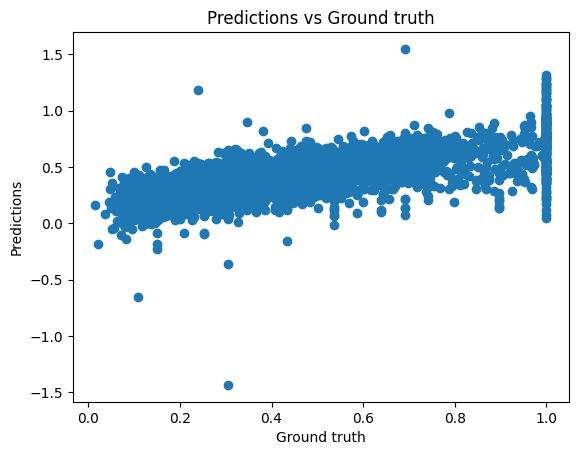

Custom Pearson R: 0.6936542730663815
Baseline Pearson R: 0.7672722723781259
Custom test MSE loss: 0.09402263909578323
Baseline test MSE loss: 0.02439041994512081


In [22]:
# plot the predictions on the test set and compute the MSELoss and Pearson R.

y_hat_custom = custom_model(X_test)
plt.scatter(y_test.cpu(), y_hat_custom.cpu())
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground truth')
plt.show()

test_R_custom = scipy.stats.pearsonr(y_hat_custom[:,0].cpu(), y_test.cpu())[0]
print(f'Custom Pearson R: {test_R_custom}')
print(f'Baseline Pearson R: {R}')

test_loss_custom = MSEloss(y_hat_custom, y_test)
print(f'Custom test MSE loss: {test_loss_custom}')
print(f'Baseline test MSE loss: {loss}')